# Model #1 Univariate LSTM (Covid Deaths)

* Import owid_covid_dataset.csv
* Using COVID-19 Total Daily Deaths as input into an LSTM model to predict COVID-19 Total Daily Deaths.

# Imports

In [1]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import tensorflow as tf
print(tf.__version__)

# Libraries
import pathlib
import numpy as np
import pandas as pd
from numpy import array

# Plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams

# Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout
from numpy.random import seed
from random import shuffle

# Metric
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-34ig2xi6
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-34ig2xi6
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0b6c19867d6ef4ef69f6ed5688eaf92c4a3145b79_-cp36-none-any.whl size=139117 sha256=542c55652c630e57e80b8cd9880550cfb71996d3024e9856949356e0f2c9e798
  Stored in directory: /tmp/pip-ephem-wheel-cache-dhj_r51h/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [2]:
seed(1)
tf.random.set_seed(2)

# Data Collection


In [6]:
# Importing covid_dataset
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
dataset = covid_dataset.loc[covid_dataset.location=='United States', ['date', 'total_cases', 'total_deaths']]
dataset.head()

,date,total_cases,total_deaths
32403,2019-12-31,0.0,0.0
32404,2020-01-01,0.0,0.0
32405,2020-01-02,0.0,0.0
32406,2020-01-03,0.0,0.0
32407,2020-01-04,0.0,0.0


### Plotting Accumulative Daily Deaths before Normalisation


In [9]:
date = dataset['date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
my_xticks = dateFormatting['new_date'].tolist()

In [10]:
# Adds the accumulative deaths every day of a country
total_deaths = dataset['total_deaths']
newDayDeaths = 0
daily_total_deaths = []
for dailyDeaths in total_deaths:
  newDayDeaths = dailyDeaths + newDayDeaths
  daily_total_deaths.append(newDayDeaths)



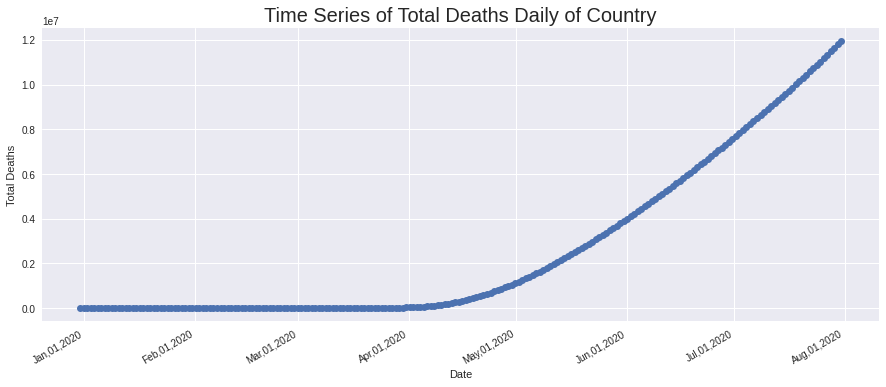

In [40]:
# Plots the accumulative daily death rates of a country
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
deaths = np.array(daily_total_deaths)
plt.plot_date(dates, deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths Daily of Country', size = 20)
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)


### Plotting Features after Normalisation

In [12]:
deaths_frame = pd.DataFrame(np.concatenate([deaths]), columns= ["total_deaths"])
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_deaths= scaler.fit_transform(deaths_frame).reshape(-1,1)

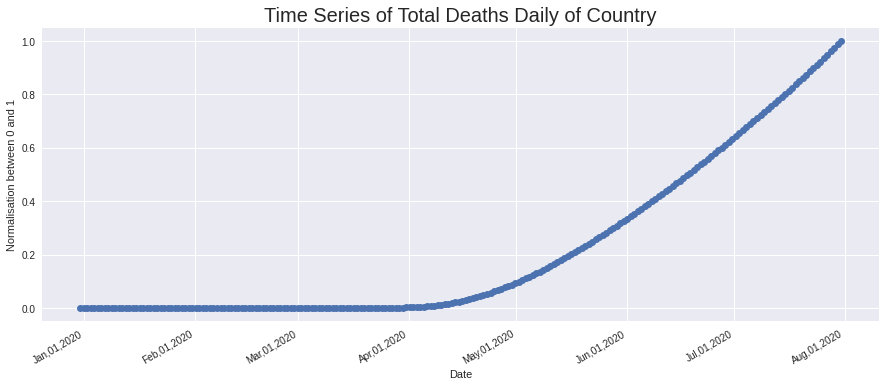

In [41]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
plt.plot_date(dates, normalisation_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title('Time Series of Total Deaths Daily of Country', size = 20)
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.show()


# Splitting Data into Train, Validation & Test


In [14]:
new_dataset = normalisation_deaths

In [15]:
# Test, Validation, Train 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(174, 1)
(22, 1)
(22, 1)


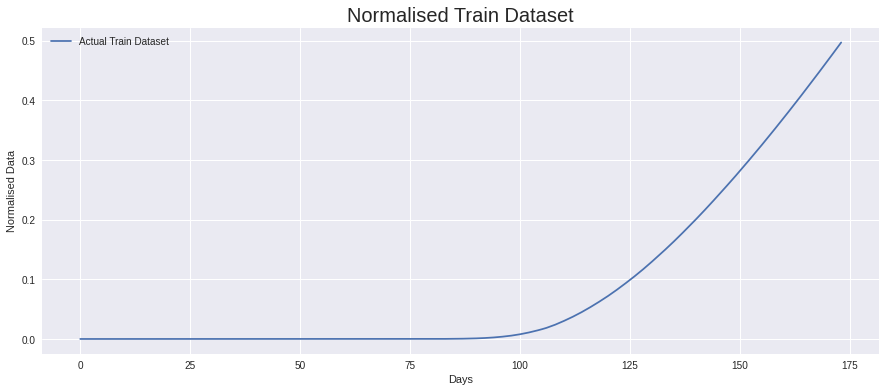

In [16]:
# Start – Train
rcParams['figure.figsize'] = 15,6
plt.plot(train_data, label="Actual Train Dataset")
plt.title('Normalised Train Dataset', size = 20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

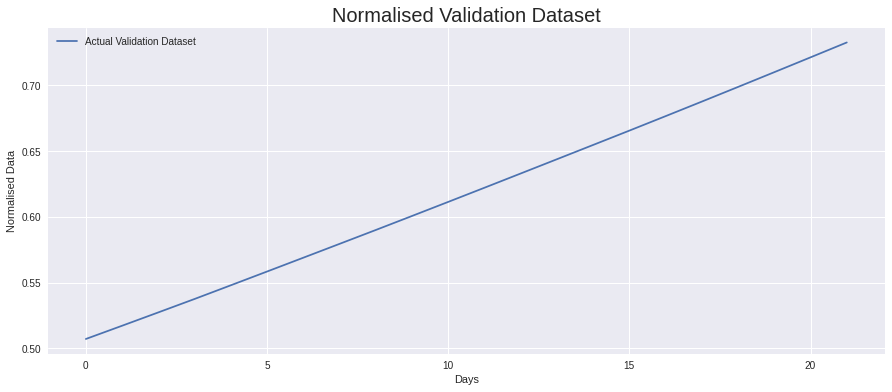

In [17]:
# Middle – Validation
rcParams['figure.figsize'] = 15,6
plt.plot(valset_data, label="Actual Validation Dataset")
plt.title('Normalised Validation Dataset', size = 20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

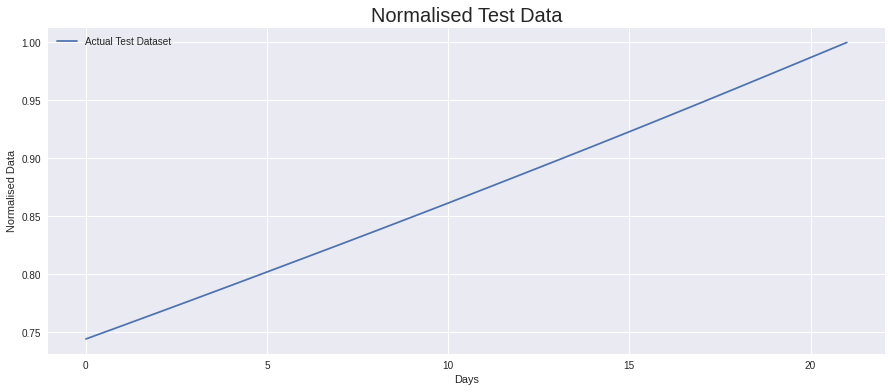

In [18]:
# End - Test
rcParams['figure.figsize'] = 15,6
plt.plot(test_data, label="Actual Test Dataset")
plt.title('Normalised Test Data', size =20)
plt.ylabel('Normalised Data')
plt.xlabel('Days')
plt.legend()
plt.show()

# X_train, Y_train, X_test, Y_test

*   time_step: previous days to consider before making prediction



In [19]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
  dataX, dataY = [],[]
  # range: is the days in dataset - the days we need to consider - the 8th day
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i -> 6th day
    dataX.append(a) 
    y = dataset[i + time_step] # 7th day
    dataY.append(y)
  return np.array(dataX), np.array(dataY)

In [20]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)

# Stacked LSTM Model

In [21]:
def lstm_model(lr_rate, neuron_layer, optimizer_one):
  model = Sequential()
  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)
  model.add(InputLayer(input_shape=(7,1)))
  model.add(LSTM(neuron_layer, return_sequences=True))
  model.add(Dense(10))
  model.add(LSTM(neuron_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=opt)
  return model


  

  

### Hyperparameter Tuning
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)




In [22]:
# Function to create the best model for hyperparameters method
def bestModel(least_loss, learning_rate_list, optimizer_list, neuron_list):
  for each_neuron in neuron_list:
    for each_optimizer in optimizer_list:
      for each_learning_rate in learning_rate_list:
        our_model = lstm_model(each_learning_rate, each_neuron, each_optimizer)
        our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        loss = our_model.evaluate(X_test, Y_test)
        if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_neuron = each_neuron
    return least_loss, best_learning_rate, best_optimizer, best_neuron

#### Grid Search



In [23]:
neuron_list = [15,30,10]
optimizer_list = ['adam', 'adamax']
learning_rate_list = [3e-3,3e-4]
least_loss_grid_search = 1

best_grid_search_model = bestModel(least_loss_grid_search, learning_rate_list, optimizer_list, neuron_list)
print(best_grid_search_model)


Epoch 1/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0072 - val_loss: 0.0105
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 4.4639e-04
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 4.2340e-04 - val_loss: 0.0044
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 1.1793e-04 - val_loss: 1.0972e-05
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 8.4892e-05 - val_loss: 3.4932e-04
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 6.0658e-05 - val_loss: 1.1951e-05
Epoch 7/100
1/1 [==============================] - 0s 978us/step - loss: 0.0012
Epoch 1/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0259 - val_loss: 0.3879
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.3153
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.

#### Random Search


In [24]:
# Shuffling neuron layers
neuron_list = [15,30,10]
# Seed random number generator
seed(len(neuron_list))
# Prepare a sequence
neuron_sequence = neuron_list
print(neuron_sequence) # Before Shuffle
# Randomly shuffle the sequence hidden layers
shuffle(neuron_sequence) 
print(neuron_sequence) # After Shuffle

[15, 30, 10]
[30, 10, 15]


In [25]:
# Shuffling optimizers

optimizer_list = ['adam', 'adamax']
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
op_sequence = optimizer_list
print(op_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(op_sequence)
print(op_sequence) # After Shuffle

['adam', 'adamax']
['adamax', 'adam']


In [26]:
# Shuffling learning rate

learning_rate_list = [3e-3,3e-4]
# Seed random number generator
seed(len(neuron_sequence))
# Prepare a sequence
lr_sequence = learning_rate_list
print(lr_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(lr_sequence)
print(lr_sequence) # After Shuffle


[0.003, 0.0003]
[0.003, 0.0003]


In [27]:
# Assigning least_loss
least_loss_random_search = 1

In [28]:
best_random_grid_model = bestModel(least_loss_random_search, lr_sequence, op_sequence, neuron_sequence)
print(best_random_grid_model)

Epoch 1/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0127 - val_loss: 0.0408
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0118
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 2.9847e-04 - val_loss: 8.4965e-04
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 1.3840e-04 - val_loss: 0.0052
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 9.1871e-05 - val_loss: 0.0034
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 1/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0237 - val_loss: 0.3579
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.3121
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.2736
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.2424
Epoch 5/100
1

#### Deciding on best hyperparameter results

In [29]:
# We want the smallest loss
# Therefore if random_search least loss is greater than grid search, make grid search best model the best model.
# 0 = least loss, 1 = learning rate, 2 = optimizer, 3 = neurons
if best_grid_search_model[0] > best_random_grid_model[0]:
  best_learning_rate = best_random_grid_model[1]
  best_optimizer = best_random_grid_model[2]
  best_neuron = best_random_grid_model[3]
else:
  best_learning_rate = best_grid_search_model[1]
  best_optimizer = best_grid_search_model[2]
  best_neuron = best_grid_search_model[3]
print(best_learning_rate)
print(best_optimizer)
print(best_neuron)

0.0003
adam
30


# Best Model Prediction

In [30]:
best_param_model = lstm_model(best_learning_rate, best_neuron, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=150,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) 

Epoch 1/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 2/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 3/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 4/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5/150
17/17 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 6/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 7/150
17/17 [==============================] - 0s 5ms/step - loss: 8.9251e-04
Epoch 8/150
17/17 [==============================] - 0s 6ms/step - loss: 2.0198e-04
Epoch 9/150
17/17 [==============================] - 0s 5ms/step - loss: 1.7194e-04
Epoch 10/150
17/17 [==============================] - 0s 6ms/step - loss: 1.5879e-04
Epoch 11/150
17/17 [==============================] - 0s 5ms/step - loss: 1.5623e-04
Epoch 12/150
17/17 [==============================] - 0s 4ms/step - loss: 1.4965e-04
Epoch 13/150


# Using best model to predict on X_train & X_test

In [31]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(166, 1)
(14, 1)


# Performance Metric





In [32]:
print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, test_predict))

0.002607261755964325
0.1363788696307011


In [33]:
print(mean_squared_error(Y_train, train_predict))
print(mean_squared_error(Y_test, test_predict))

1.5253175011011852e-05
0.019118121928430282


# Plotting Train Prediction, Validation & Test Prediction Versus Actual Data

In [34]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict =scaler.inverse_transform(test_predict)


### Train Predicted

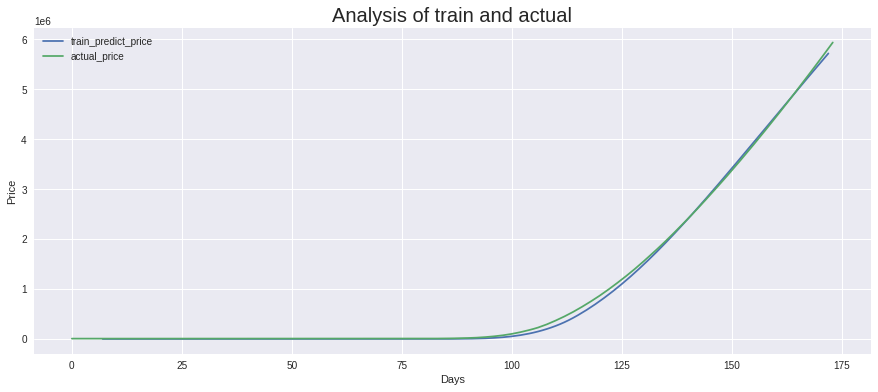

In [35]:
look_back = 7

trainPredictPlot = np.empty_like(new_dataset) # shape
trainPredictPlot[:,:]= np.nan # values at 0
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict # Populates: 7 -> 162 + 7 = 169

trainPredictPlot = [item[0] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict_price")

train_panda = pd.DataFrame(train_data)
plt.plot(scaler.inverse_transform(train_panda), label="actual_price")

rcParams['figure.figsize'] = 15,6
plt.title('Analysis of train and actual', size = 20)
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

## Using last 7 days of training data to predict validation data. 



In [36]:
temp_input = train_data[-7:]
temp_input

array([[0.43777049],
       [0.44748836],
       [0.4572762 ],
       [0.46712712],
       [0.47703805],
       [0.48700572],
       [0.49702419]])

In [37]:
# Demonstrate prediction for the next 4 as an example(but 21) days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

custom_day = len(valset_data)
lst_output=[]
n_steps=7
i=0
X_input = temp_input
# print(X_input)
while(i<custom_day):
  if(len(temp_input)>7):
    # print(temp_input)  
    X_input=array(temp_input[1:])
    # print("{} day input {}".format(i,X_input))
    # Correct input shape (1,7,3)
    X_input=X_input.reshape((1,n_steps,1))
    # Prediction of X_input
    # print(X_input)
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,1))
    Y_hat = best_param_model.predict(X_input, verbose=0)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
print(lst_output)

[0.4957659, 0.50386554, 0.5114715, 0.51853985, 0.5250228, 0.5308639, 0.535994, 0.54033035, 0.5459683, 0.5511458, 0.5559116, 0.560321, 0.5644378, 0.5683373, 0.57211214, 0.57587576, 0.5793619, 0.5826169, 0.5856793, 0.5885801, 0.59134066, 0.5939708]


## Plotting evaluation: Training Prediction of Validation Data

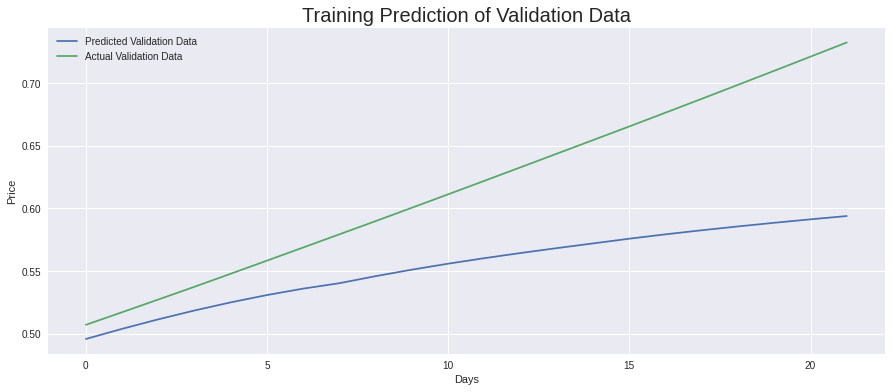

In [38]:
# Custom day plotted
day_new = custom_day-1

# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
# print("Predicted validation:")
# print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted Validation Data")

# Transform back to original value before normalised
val_data = [item[0] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
# print("Actual validation:")
# print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual Validation Data")

rcParams['figure.figsize'] = 15,6
plt.title('Training Prediction of Validation Data', size = 20)
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


## Test Plot

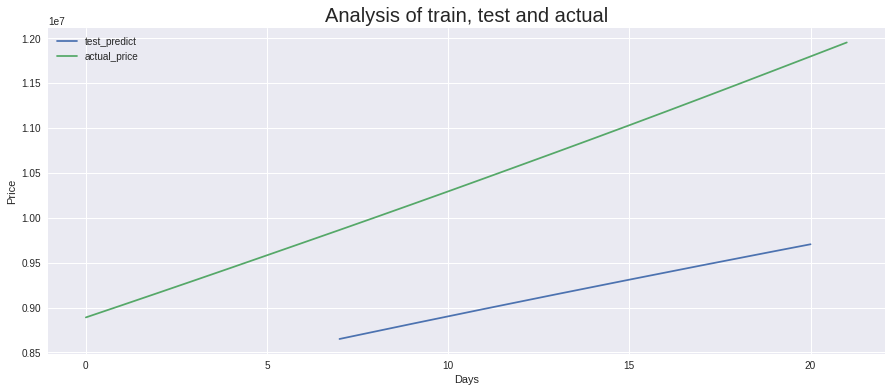

In [39]:
look_back = 7

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[look_back:len(test_predict)+look_back] = test_predict
# 14 + (7*2) + 1 : 163 + 14 = test_predict
# 22:177 = test predict

testPredictPlot = [item[0] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

test_panda = pd.DataFrame(test_data)
plt.plot(scaler.inverse_transform(test_panda), label="actual_price")

rcParams['figure.figsize'] = 15,6
plt.title('Analysis of train, test and actual', size = 20)
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()
